# UMAP 

### Installing and loading libraries

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import librosa.display

In [2]:
from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore

### Setting constants

Setting project, input and output folders.

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

DF_DICT = {}
for dftype in ['full', 'reduced', 'balanced']:
    DF_DICT[dftype] = os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl")

In [40]:
LOAD_EXISTING = True # load existing embedding

# UMAP projection

### Choose dataset

In [55]:
dftype='full'
dftype='reduced'
dftype='balanced'

spec_df = pd.read_pickle(DF_DICT[dftype])
spec_df.shape

(1148, 29)

### Choose feature

In [56]:
specs = spec_df.spectrograms.copy()

# normalize feature
specs = [calc_zscore(x) for x in specs] 

# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

(1148, 5320)

## Run UMAP

In [57]:
embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_'+dftype+'_default_params.csv')
print(embedding_filename)
if (LOAD_EXISTING and os.path.isfile(embedding_filename)):
    embedding = np.loadtxt(embedding_filename, delimiter=";")
    print("File already exists")
else:
    reducer = umap.UMAP(n_components=3, min_dist = 0, random_state=2204)
    embedding = reducer.fit_transform(data)
    np.savetxt(embedding_filename, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_balanced_default_params.csv
File already exists


In [7]:
reducer2D = umap.UMAP(n_components = 2, min_dist = 0, random_state=2204)
embedding2D = reducer2D.fit_transform(data) 

## Visualization

In [58]:
labels = spec_df.call_lable.values
pal="Set2"

### 2D Plots

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAP_2D_plot_balanced_nolegend.jpg


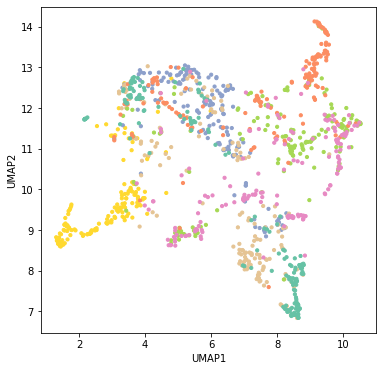

In [11]:
outname = os.path.join(os.path.sep, FIGURES, 'UMAP_2D_plot_'+dftype+'_nolegend.jpg')
print(outname)
umap_2Dplot(embedding2D[:,0], embedding2D[:,1], labels, pal, outname=outname, showlegend=False)

### 3D Plot

#### Matplotlib 

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAP_3D_plot_reduced_nolegend.jpg


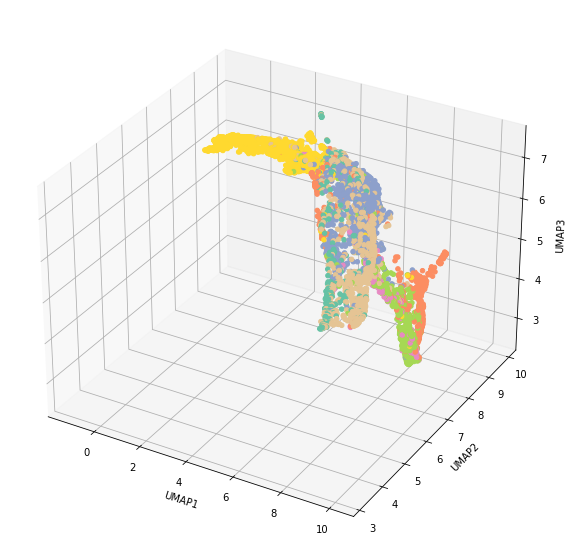

In [37]:
outname = os.path.join(os.path.sep, FIGURES, 'UMAP_3D_plot_'+dftype+'_nolegend.jpg')
print(outname)

mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            labels,
            pal,
            outname,
            showlegend=False)

#### Plotly

In [13]:
#plotly_viz(embedding[:,0],
#           embedding[:,1],
#           embedding[:,2],
#           labels,
#           pal)

# Embedding evaluation

Evaluate the embedding based on calltype labels of nearest neighbors.

In [52]:
from evaluation_functions import nn

In [60]:
nn_stats = nn(embedding, np.asarray(labels), k=5)

## Calculate metrics

In [61]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

Log final metric (unweighted): 61.63763066202091
Abs final metric (unweighted): 2.0878095014523903


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatS_UMAP_balanced.png


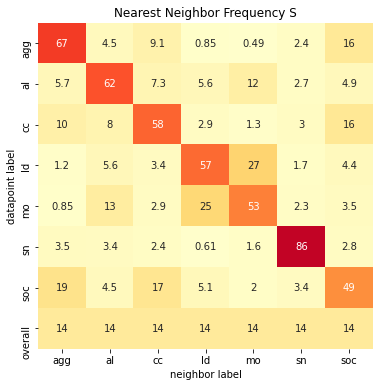

In [18]:
outname = os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+dftype+'.png')
print(outname)

nn_stats.plot_heat_S(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatSnorm_UMAP_balanced.png


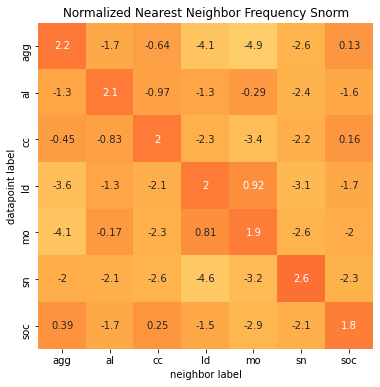

In [19]:
outname = os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+dftype+'.png')
print(outname)

nn_stats.plot_heat_Snorm(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatfold_UMAP_balanced.png


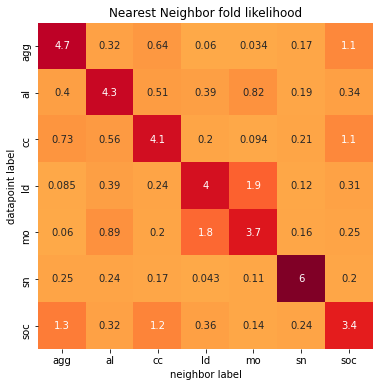

In [20]:
outname = os.path.join(os.path.sep, FIGURES, 'heatfold_UMAP_'+dftype+'.png')
print(outname)

nn_stats.plot_heat_fold(outname=outname)

# Within vs. outside distances

In [21]:
from scipy.spatial.distance import pdist, squareform

In [22]:
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

In [23]:
distmat_embedded = squareform(pdist(embedding, metric='euclidean'))

In [24]:
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
    x=distmat_embedded[np.where(labels==calltype)]
    x = np.transpose(x)  
    y = x[np.where(labels==calltype)]
   
    self_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1],k = 1)]
    y = x[np.where(labels!=calltype)]
    other_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1], k = 1)]

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-11_distanceswithinwithout_balanced.jpg


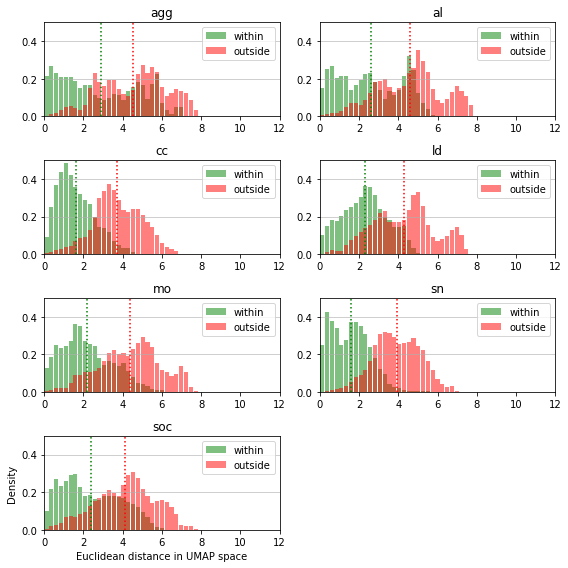

In [25]:
plt.figure(figsize=(8, 8))
i=1

xmin=0
xmax=12
nbins=50
    
for calltype in calltypes:
    
    plt.subplot(4, 2, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="outside", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              alpha=0.5, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
    s, pval = scipy.stats.ttest_ind(self_dists[calltype],other_dists[calltype])

    if pval<0.01:
        pval = "p<0.01"
    else:
        pval = "p="+str(round(pval,2))

    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    #plt.title(calltype+" ("+pval+")")
    plt.title(calltype)
    plt.xlim(xmin,xmax)
    plt.ylim(0, 0.5)
    if i==len(calltypes):      
        plt.ylabel('Density')
        plt.xlabel('Euclidean distance in UMAP space')

    i=i+1

plt.tight_layout()
outname=os.path.join(os.path.sep, FIGURES, 'distanceswithinwithout_'+dftype+'.jpg')
print(outname)
plt.savefig(outname, facecolor="white")

## Silhouette Plot

In [26]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [27]:
umap_df = spec_df

In [28]:
embedding.shape

(1148, 3)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-11_UMAP_silhouette_balanced.jpg


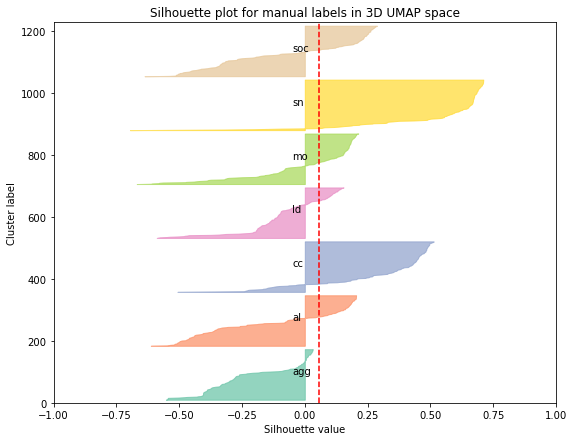

In [29]:
labels = umap_df.call_lable
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(9, 7)

ax1.set_xlim([-1, 1])

ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for manual labels in 3D UMAP space")
ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

outname = os.path.join(os.path.sep, FIGURES, 'UMAP_silhouette_'+dftype+'.jpg')
print(outname)
plt.savefig(outname, facecolor="white")

In [28]:
# Original % with pos scores
sample_silhouette_values = silhouette_samples(data, cluster_labels)
print(sample_silhouette_values[sample_silhouette_values>0].shape[0]/sample_silhouette_values.shape[0])

0.5665629860031104


In [29]:
# UMAP % with pos scores
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
print(sample_silhouette_values[sample_silhouette_values>0].shape[0]/sample_silhouette_values.shape[0])

0.7227060653188181


Sil scores and % with negative scores as unweighted average per class

In [30]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

prop_pos_dict_UMAP = {}
sil_UMAP ={}

#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
    pos_vals = ith_cluster_silhouette_values[ith_cluster_silhouette_values>0]
    print(cluster_label, ": ", pos_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100)
    prop_pos_dict_UMAP[cluster_label] = pos_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100
    sil_UMAP[cluster_label] = np.mean(ith_cluster_silhouette_values)


agg :  0.0
al :  49.22600619195047
cc :  92.0785375761679
ld :  26.21951219512195
mo :  72.85902503293808
sn :  94.39353099730458
soc :  53.89948006932409


## How many dimensions?

Evaluate, how many dimensions are best for the embedding.

In [32]:
specs = spec_df.denoised_spectrograms.copy()
# normalize feature
specs = [calc_zscore(x) for x in specs] 
# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

embeddings = {}
for n_dims in range(1,11):
    reducer = umap.UMAP(n_components = n_dims, min_dist = 0, metric='euclidean', random_state=2204)
    embeddings[n_dims] = reducer.fit_transform(data)    

In [33]:
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))
k=5
dims_tab = np.zeros((10,1))

for n_dims in range(1,11):
    nn_stats = nn(embeddings[n_dims], labels, k=k)
    stats_tab = nn_stats.get_statstab()
    mean_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    print(mean_metric)
    dims_tab[n_dims-1,:] = mean_metric

53.12653699833821
60.16721465425428
62.86065563813761
63.774428388864706
63.90020006772353
63.339635059559846
63.68077434125937
63.76823437168046
63.46266574754633
63.622721378310494


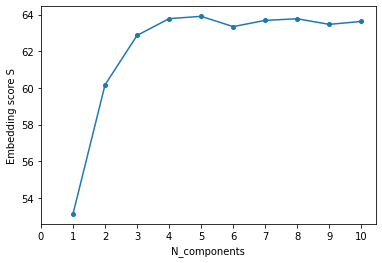

In [60]:
x = np.arange(1,11,1)
y = dims_tab[:,0]
plt.plot(x,y, marker='o', markersize=4)
plt.xlabel("N_components")
plt.ylabel("Embedding score S")
plt.xticks(np.arange(0, 11, step=1))
plt.savefig(os.path.join(os.path.sep,FIGURES,'n_dims.png'), facecolor="white")

Note that this is different than doing UMAP with n=10 components and then selection only the first x dimensions in UMAP space!

# Graph from embedding evaluation

Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

In [36]:
nn_stats = nn(embedding, labels, k=k)
stats_tab_norm = nn_stats.get_statstabnorm()
stats_tab_norm

,agg,al,cc,ld,mo,sn,soc
agg,2.972015,-1.885037,-1.064025,-3.257696,-3.790028,-3.653011,1.048444
al,-1.448938,2.763803,-1.529545,-0.691842,-0.212728,-2.340357,-2.091680
cc,-1.057039,-1.740754,1.751800,-1.972369,-2.790455,-3.114468,-0.687458
ld,-3.257696,-0.609380,-1.407584,3.388358,1.942326,-4.078726,-0.791914
mo,-3.620103,-0.212728,-2.463955,1.641572,2.612196,-3.213842,-2.378286
sn,-3.653011,-2.471601,-3.150092,-4.564152,-3.355018,1.676145,-3.415554
soc,1.035953,-2.410959,-0.528286,-0.406889,-2.324246,-3.258013,1.809971


In [37]:
import networkx as nx
import string
import pygraphviz

In [38]:
sim_mat = np.asarray(stats_tab_norm).copy()

for i in range(sim_mat.shape[0]):
    for j in range(i,sim_mat.shape[0]):
        if i!=j:
            sim_mat[i,j] = np.mean((sim_mat[i,j], sim_mat[j,i]))
            sim_mat[j,i] = sim_mat[i,j]
        else:
            sim_mat[i,j] = 0

In [39]:
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6
0,0.000000,-1.666987,-1.060532,-3.257696,-3.705065,-3.653011,1.042199
1,-1.666987,0.000000,-1.635149,-0.650611,-0.212728,-2.405979,-2.251319
2,-1.060532,-1.635149,0.000000,-1.689976,-2.627205,-3.132280,-0.607872
3,-3.257696,-0.650611,-1.689976,0.000000,1.791949,-4.321439,-0.599401
4,-3.705065,-0.212728,-2.627205,1.791949,0.000000,-3.284430,-2.351266
5,-3.653011,-2.405979,-3.132280,-4.321439,-3.284430,0.000000,-3.336783
6,1.042199,-2.251319,-0.607872,-0.599401,-2.351266,-3.336783,0.000000


In [40]:
dist_mat = sim_mat*(-1)
dist_mat = np.interp(dist_mat, (dist_mat.min(), dist_mat.max()), (1, 10))

In [41]:
for i in range(dist_mat.shape[0]):
    dist_mat[i,i] = 0

In [42]:
pd.DataFrame(dist_mat, columns=calltypes, index=calltypes)

,agg,al,cc,ld,mo,sn,soc
agg,0.000000,6.092172,5.199362,8.433980,9.092588,9.015954,2.103766
al,6.092172,0.000000,6.045301,4.595885,3.951242,7.180101,6.952414
cc,5.199362,6.045301,0.000000,6.126016,7.505784,8.249345,4.532965
ld,8.433980,4.595885,6.126016,0.000000,1.000000,10.000000,4.520495
mo,9.092588,3.951242,7.505784,1.000000,0.000000,8.473337,7.099553
sn,9.015954,7.180101,8.249345,10.000000,8.473337,0.000000,8.550410
soc,2.103766,6.952414,4.532965,4.520495,7.099553,8.550410,0.000000


In [51]:
dt = [('len', float)]
A = dist_mat

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),calltypes))) 

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="#bec1d4", style="filled", shape='circle', fontsize='20')
G.edge_attr.update(color="blue", width="2.0")

G.draw(os.path.join(os.path.sep,FIGURES,'simgraph.png'), format='png', prog='neato')

# Make interactive plot df

In [ ]:
embedding.head(3)

,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id
0,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598
1,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599
2,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600


In [ ]:
embedding.columns = ['UMAP'+str(col) for col in embedding.columns]
embedding.columns

Index(['UMAP0', 'UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7',
       'UMAP8', 'UMAP9', 'UMAPindex_id'],
      dtype='object')

In [ ]:
for col in embedding.columns:
  spec_df[col] = embedding[col].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600


In [ ]:
# Add metadata

In [ ]:
sorted(list(set(spec_df['indv'])))
meerkat_info = pd.read_csv(PROJECT_PATH+'Meerkat_info.csv', sep=";")

meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match ? * ! %
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
        meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "is actually ", ind_code)
    else:
      print(ind, "not in dyemarks")

HMB is actually  VCVM001
HRT not in dyemarks
HTB is actually  VHMF001
LT is actually  VHMF031
PET not in dyemarks
RT is actually  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']
meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Dominant'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }
for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'NA', 
                         'Dye mark': 'NA', 
                         'Sex': 'NA', 
                         'Status':'NA'}

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in spec_df['indv']]
spec_df['Sex'] = sex
status = [meerkat_dict[ind]['Status'] for ind in spec_df['indv']]
spec_df['status'] = status

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filename = [os.path.basename(wav_path) for wav_path in spec_df['original_wav']]
spec_df['filename'] = filename

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(5)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id,Sex,status,filename
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1601,ALARM,1:12:15.427,0:00.134,decimal,Cue,NaN,y,4335.427,0.134,4335.561,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM

In [ ]:
filename = [x[:-4] for x in filename]

In [ ]:
filename_1 = [x[0:30] for x in filename]
filename_2 = [x[30:60] if len(x)>60 else x[30:] for x in filename]
filename_3 = [x[60:] if len(x)>60 else '' for x in filename]

In [ ]:
spec_df['fn_1'] = filename_1
spec_df['fn_2'] = filename_2
spec_df['fn_3'] = filename_3

In [ ]:
plot_df = spec_df[['Name', 'call_lable', 'indv', 'raw_audio', 
                   'denoised_spectrograms','duration_s', 'samplerate_hz', 
                  'UMAP0', 'UMAP1', 'UMAP2', 'index_id', 'Sex', 'status', 'Start', 'fn_1',
                   'fn_2', 'fn_3']]

In [ ]:
plot_df = plot_df.drop(columns=['denoised_spectrograms'])

In [ ]:
plot_df.head(3)

,Name,call_lable,indv,raw_audio,duration_s,samplerate_hz,UMAP0,UMAP1,UMAP2,index_id,Sex,status,Start,fn_1,fn_2,fn_3,HDBSCAN
1598,ALARM,al,HMB,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...",0.178,8000,5.299764,6.417554,4.202350,1598,M,Dominant,1:10:56.215,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,-1
1599,ALARM,al,HMB,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...",0.317,8000,6.663779,7.219666,3.152430,1599,M,Dominant,1:12:04.643,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,-1
1600,ALARM,al,HMB,"[0.005859375, 0.005859375, 0.0078125, 0.005859...",0.192,8000,6.665429,6.820063,4.278993,1600,M,Dominant,1:12:15.132,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,5


In [ ]:
os.system('pip install hdbscan')
import hdbscan

In [ ]:
cluster_df = np.asarray(embedding.iloc[:,0:10])
cluster_df.shape

(6687, 10)

In [ ]:
# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=66, #20, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=10, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6687
Number of classes:  13
Unassigned:  3167 ( 0.4736055032151937 )


In [ ]:
#plot_df['HDBSCAN'] = HDBSCAN.labels_

plot_df.to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta')

In [ ]:
plot_df.iloc[:3000,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
plot_df.iloc[3000:,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

# Visualize example nearest neighbors

In [52]:
import random
import scipy
from sklearn.neighbors import NearestNeighbors

In [53]:
knn=5
n_examples=3
# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [54]:
calltypes = sorted(list(set(spec_df['call_lable'])))
labels = spec_df.call_lable.values
names = spec_df.Name.values

In [59]:
# make plots

for calltype in calltypes:

    fig = plt.figure(figsize=(14,6))
    fig_name = 'NN_Viz_denoised_'+calltype
    k=1
    call_indices = np.asarray(np.where(labels==calltype))[0]

    # randomly choose 3
    example_indices = random.sample(list(call_indices), n_examples)

    for i,ind in enumerate(example_indices):
        img_of_interest = spec_df.iloc[ind,:].denoised_spectrograms
        embedding_of_interest = embedding[ind,:]
        plt.subplot(n_examples, knn+1, k)
        #librosa.display.specshow(np.transpose(spec))
        plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
        plt.title(calltype+' : 0')
        k=k+1

        nearest_neighbors = indices[ind]
        for neighbor in nearest_neighbors:
            neighbor_label = names[neighbor]
            neighbor_embedding = embedding[neighbor,:]
            dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
            neighbor_img = spec_df.iloc[neighbor,:].denoised_spectrograms
            plt.subplot(n_examples, knn+1, k)
            #librosa.display.specshow(np.transpose(spec))
            plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
            plt.title(neighbor_label+' : '+str(round(dist_to_original, 2)))
            k=k+1
        
    plt.tight_layout() 
    plt.savefig(os.path.join(os.path.sep,FIGURES,fig_name), facecolor="white")
    plt.close()

# Files for Frants 2

In [ ]:
files = os.listdir(DATA+'frants/')

In [ ]:
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load(open("meerkat_channel.json"))

In [ ]:
files = os.listdir(DATA+'frants/')
fileIDs = [int(x.split('_')[0]) for x in files]

In [ ]:
def get_audio(wav_loc, start_s, duration_s):
    # SOUNDFOCs are stereo
    if "SOUNDFOC" in wav_loc:
        data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
        data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
    else:
        data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

    if np.issubdtype(type(data[0]), np.integer):
        data = int16_to_float32(data)
    
    return data

In [ ]:
for fileID, filename in zip(fileIDs, files):
    sr = df.loc[df['index_id']==fileID,'samplerate_hz'].values[0]
    dur = df.loc[df['index_id']==fileID,'duration_s'].values[0]
    offset = df.loc[df['index_id']==fileID,'start_s'].values[0]
    wav_loc = df.loc[df['index_id']==fileID,'original_wav'].values[0]

    # add padding
    dur = dur+0.2
    offset = offset-0.1

    y = get_audio(wav_loc, offset, dur)
    librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, y, sr, norm=False)

In [ ]:
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id,Sex,status,filename
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...


# Visualize preprocessing steps

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/preprocessing_examples_mara.png


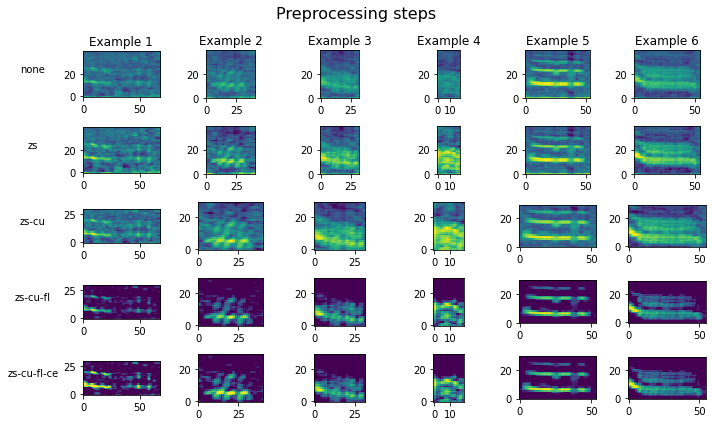

In [152]:
N_MELS = 40
MEL_BINS_REMOVED_UPPER = 5
MEL_BINS_REMOVED_LOWER = 5

# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(10,6))
fig_name = 'preprocessing_examples_mara.png'

fig.suptitle('Preprocessing steps', fontsize=16)
k=1

# randomly choose 4
examples = spec_df.sample(n=6, random_state=1)
examples.reset_index(inplace=True)
ori_specs = examples.denoised_spectrograms


# original

specs = ori_specs
vmin = np.min([np.min(x) for x in specs])
vmax = np.max([np.max(x) for x in specs])

for i in range(examples.shape[0]):
    spec = specs[i]
    plt.subplot(5, 6, k)
    #librosa.display.specshow(spec, y_axis='mel', fmin=0, fmax=4000)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal', norm=None,vmin=vmin, vmax=vmax)
    if i==0: plt.ylabel('none', rotation=0, labelpad=30)
    plt.title("Example "+str(i+1))
    k=k+1

# z-score
specs = ori_specs.copy()
#specs = [x[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:] for x in specs]
specs = [calc_zscore(s) for s in specs]
#vmin = np.min([np.min(x) for x in specs])
#vmax = np.max([np.max(x) for x in specs])
for i in range(examples.shape[0]):
    spec = specs[i]
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal')
    if i==0: plt.ylabel('zs', rotation=0, labelpad=30)
    k=k+1

# cut
for i in range(examples.shape[0]):
    spec = ori_specs[i]
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    if i==0: plt.ylabel('zs-cu', rotation=0, labelpad=30)
    k=k+1

# floor
for i in range(examples.shape[0]):
    spec = ori_specs[i]
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec < 0, 0, spec)
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    if i==0: plt.ylabel('zs-cu-fl', rotation=0, labelpad=30)
    k=k+1

# ceiling
for i in range(examples.shape[0]):
    spec = ori_specs[i]

    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec < 0, 0, spec)
    spec = np.where(spec > 3, 3, spec)
    plt.subplot(5, 6, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
    if i==0: plt.ylabel('zs-cu-fl-ce', rotation=0, labelpad=30)
    k=k+1

plt.tight_layout()
outname= os.path.join(os.path.sep,FIGURES,fig_name)
print(outname)
plt.savefig(outname)